IST Energy Services course, 2nd Semestre 2022-2023
Project 1 by Guilherme Almeida, 92686

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import  metrics

In [2]:
# Read raw input data
raw_meteo = pd.read_csv('./IST_meteo_data_2017_2018_2019.csv')
raw_2017 = pd.read_csv('./IST_Civil_Pav_2017_Ene_Cons.csv')
raw_2018 = pd.read_csv('./IST_Civil_Pav_2018_Ene_Cons.csv')
# Merge 2017 and 2018 energy consumption data
raw_energy = pd.concat([raw_2017, raw_2018])

In [3]:
# Data preparation
raw_energy = raw_energy.reset_index(drop=True)
raw_energy['Date_start']=pd.to_datetime(raw_energy['Date_start'])

clean_energy = raw_energy.set_index(['Date_start'], drop=True)
clean_energy = clean_energy.rename({'Date_start': 'yyy-mm-dd hh::mm::s'}, axis='columns')


raw_meteo['yyyy-mm-dd hh:mm:ss']=pd.to_datetime(raw_meteo['yyyy-mm-dd hh:mm:ss'])
clean_meteo = raw_meteo.set_index(['yyyy-mm-dd hh:mm:ss'],drop=True)

clean_meteo_hourly = clean_meteo.resample('H').mean()
clean_meteo_hourly['Hour'] = clean_meteo_hourly.index.hour


In [4]:
# Manually create dates of all holidays between 2017 and 2019
holidaysData = {'Date' : ['01-01-2017','14-04-2017','16-04-2017','25-04-2017','01-05-2017','10-06-2017','13-06-2017','15-06-2017','15-08-2017','05-10-2017','01-11-2017','01-12-2017','08-12-2017','25-12-2017','01-01-2018','30-03-2018','01-04-2018','25-04-2018','01-05-2018','31-05-2018','10-06-2018','13-06-2018','15-08-2018','05-10-2018','01-11-2018','01-12-2018','08-12-2018','25-12-2018','01-01-2019','05-03-2019','19-04-2019','21-04-2019','25-04-2019','01-05-2019','10-06-2019','13-06-2019','20-06-2019','15-08-2019','05-10-2019','01-11-2019','01-12-2019','08-12-2019','25-12-2019'], 'Holiday' : True}
noWork = pd.DataFrame(data = holidaysData)
# Make date index
noWork['Date'] = pd.to_datetime(noWork['Date'], format='%d-%m-%Y')
noWork = noWork.set_index(['Date'], drop=True)

# Fill in all other days as False
fullDates = pd.date_range('2017-01-01', '2019-12-31')
noWork = noWork.reindex(fullDates, fill_value=False)

# Add weekend information
noWork['Weekend'] = noWork.index.dayofweek > 4

# Merge weekend and holiday information into one.
noWork['noWork'] = noWork.any(axis='columns')
noWork = noWork.drop(columns=['Weekend', 'Holiday'])

# Resample to hourly interval
noWork = noWork.resample('H').ffill()

In [5]:
# merge energy consumption and meteorology data together
# 'inner' makes it so only data up to the end of 2018 is included (no test data)
df = pd.merge(clean_energy,clean_meteo_hourly,how='inner',left_index=True, right_index=True)

#merge noWork with other data
df = pd.merge(df, noWork, how='left', left_index=True, right_index=True)
df['noWork'] = df['noWork'].fillna(False)

# Discard all invalid data (interpolating is quite rough and gives poor results)
df = df.dropna()

In [6]:
# Get rid of 0 power consumption values
df = df.replace({'Power_kW': 0}, np.nan)
df = df.dropna()
# Create columns with previous measurements
df['Power-1'] = df['Power_kW'].shift(1, fill_value=df['Power_kW'][0])
df['Power-2'] = df['Power_kW'].shift(2, fill_value=df['Power_kW'][0])
df['Power-3'] = df['Power_kW'].shift(3, fill_value=df['Power_kW'][0])
df['Power-4'] = df['Power_kW'].shift(4, fill_value=df['Power_kW'][0])
df['Power-5'] = df['Power_kW'].shift(5, fill_value=df['Power_kW'][0])


# Start by deleting non-used features
df = df.drop(columns=['pres_mbar', 'rain_mm/h', 'rain_day'])

In [7]:
# Read raw input data
raw = pd.read_csv('./testData_2019_Civil.csv')

# Data preparation
raw = raw.reset_index(drop=True)

# Start by deleting non-used features
raw = raw.drop(columns=['pres_mbar', 'rain_mm/h', 'rain_day'])

# Set date as index
raw['Date']=pd.to_datetime(raw['Date'])

raw = raw.set_index(['Date'], drop=True)
raw = raw.rename({'Date': 'yyy-mm-dd hh::mm::s'}, axis='columns')

# Create feature: hour of the day
raw['Hour'] = raw.index.hour

# Merge input data with 'noWork' data
df_2019 = pd.merge(raw, noWork,how='inner',left_index=True, right_index=True)
# Create columns with previous measurements
value0 = df_2019['Civil (kWh)'][0]
df_2019['Power-1'] = df_2019['Civil (kWh)'].shift(1, fill_value = value0)
df_2019['Power-2'] = df_2019['Civil (kWh)'].shift(2, fill_value = value0)
df_2019['Power-3'] = df_2019['Civil (kWh)'].shift(3, fill_value = value0)
df_2019['Power-4'] = df_2019['Civil (kWh)'].shift(4, fill_value = value0)
df_2019['Power-5'] = df_2019['Civil (kWh)'].shift(5, fill_value = value0)

#Identify output Y
Yf = df.to_numpy()[:,0]
Xf = df.to_numpy()[:,[1,2,3,4,5,6,7,8,9,10,11,12]]

#Identify output Y
Y_2019 = df_2019.to_numpy()[:,0]
#Identify input X
X_2019 = df_2019.to_numpy()[:,[1,2,3,4,5,6,7,8,9,10,11,12]]

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from itertools import combinations

comb = list()
vars = [0,1,2,3,4,5,6,7,8,9,10,11]
for i in range(6,len(vars)+1) :
    comb += list(combinations(vars, i))

log_file = "log.txt"
with open(log_file, "a") as f:
  print("index, R2, MAE, MBE, MSE, RMSE, cvRMSE, NMBE", file=f)

metrics_df = pd.DataFrame(columns=['index', 'R2', 'MAE', 'MBE', 'MSE', 'RMSE', 'cvRMSE', 'NMBE'])
Y_train = Yf
Y_test = Y_2019
# for i in range(0, len(comb)):
# # for i in range(0,0):
#     XComb_train = Xf[:,comb[i]]
#     XComb_test = X_2019[:,comb[i]]

#     ss_X = StandardScaler()
#     ss_y = StandardScaler()
#     X_train_ss = ss_X.fit_transform(XComb_train)
#     y_train_ss = ss_y.fit_transform(Y_train.reshape(-1,1))

#     model_i = SVR(kernel='rbf')

#     model_i.fit(X_train_ss,y_train_ss)

#     ss_X_test = StandardScaler()
#     ss_y_test = StandardScaler()
#     X_test_ss = ss_X_test.fit_transform(XComb_test)
#     y_test_ss = ss_y_test.fit_transform(Y_test.reshape(-1,1))
#     yf_pred_SVR = model_i.predict(ss_X_test.fit_transform(XComb_test))
#     yf_pred_SVR2 = ss_y_test.inverse_transform(yf_pred_SVR.reshape(-1,1))

    
#     R2=metrics.r2_score(Y_2019, yf_pred_SVR2)
#     MAE=metrics.mean_absolute_error(Y_2019,yf_pred_SVR2)
#     MBE=np.mean(Y_2019-yf_pred_SVR2)
#     MSE=metrics.mean_squared_error(Y_2019,yf_pred_SVR2)  
#     RMSE= np.sqrt(metrics.mean_squared_error(Y_2019,yf_pred_SVR2))
#     cvRMSE=RMSE/np.mean(Y_2019)
#     NMBE=MBE/np.mean(Y_2019)
#     metrics_df = pd.concat([pd.DataFrame([[i,R2,MAE,MBE,MSE,RMSE,cvRMSE,NMBE]], columns=metrics_df.columns), metrics_df], ignore_index=True)
#     with open(log_file, "a") as f:
#         print(str(i)+','+str(R2)+','+str(MAE)+','+str(MBE)+','+str(MSE)+','+str(RMSE)+','+str(cvRMSE)+','+str(NMBE), file=f)

#     plt.plot(Y_2019)
#     plt.plot(yf_pred_SVR2)
#     plt.savefig("assets/prediction" + str(i) + ".svg")
#     # plt.show()
#     plt.clf()

#     plt.scatter(Y_2019,yf_pred_SVR2)
#     plt.axline((100,100), slope=1, color = 'black')
#     plt.savefig("assets/scatter" + str(i) + ".svg")
#     # plt.show()
#     plt.clf()

#     print("\n ----- Done comb " + str(i) + " out of " + str(len(comb)) + "\n")

# metrics_df.to_csv('assets/metrics.csv')

[]

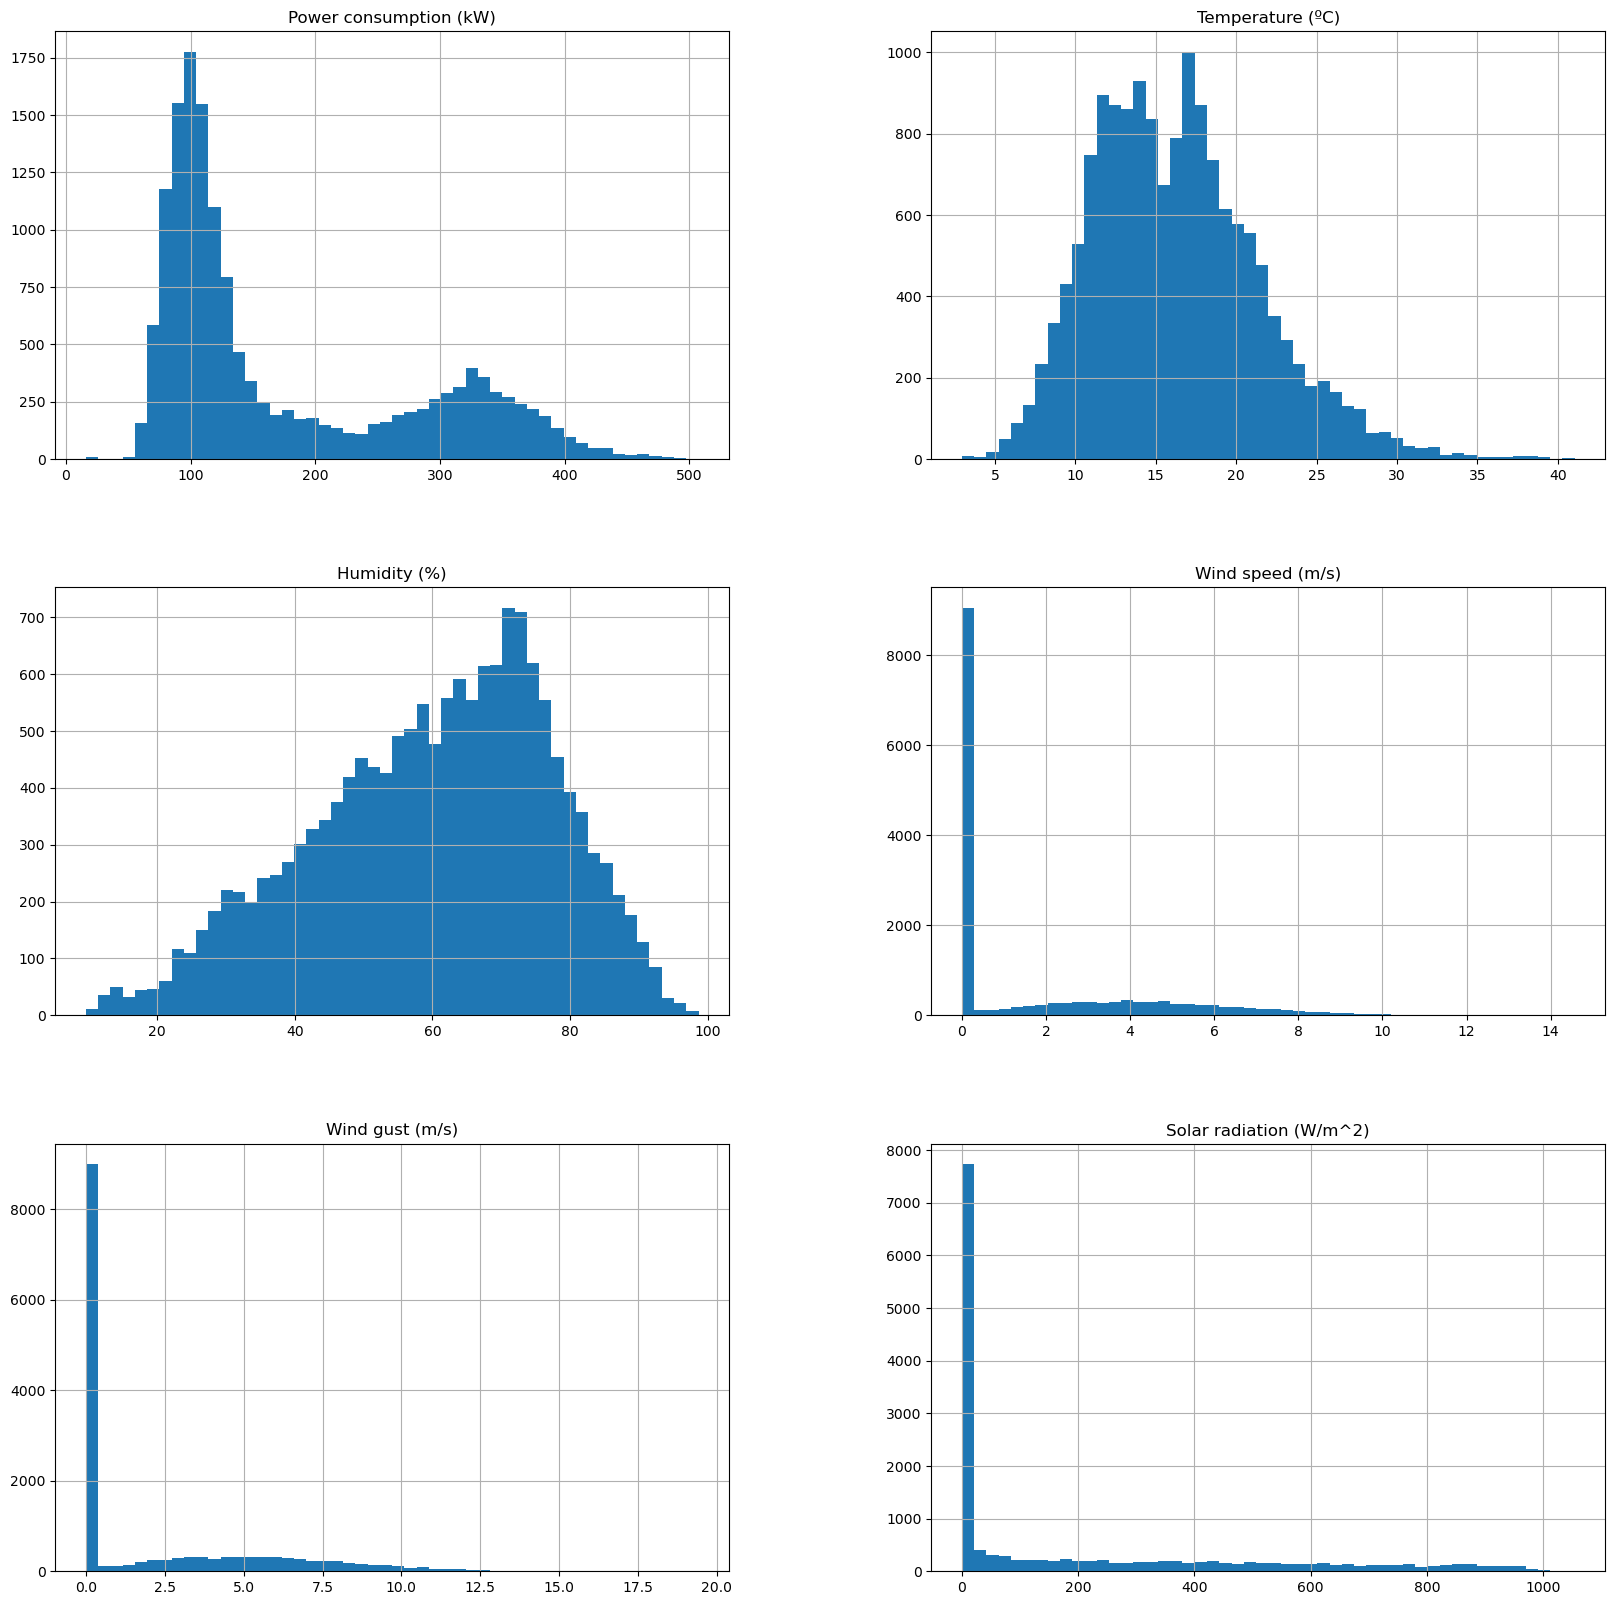

In [9]:
df_help = df
df_help[['Power consumption (kW)', 'Temperature (ºC)', 'Humidity (%)', 'Wind speed (m/s)', 'Wind gust (m/s)', 'Solar radiation (W/m^2)']] = df_help[['Power_kW', 'temp_C', 'HR', 'windSpeed_m/s', 'windGust_m/s', 'solarRad_W/m2']]
df_help = df_help.drop(columns=['Power_kW', 'temp_C', 'HR', 'windSpeed_m/s', 'windGust_m/s', 'solarRad_W/m2'])
df_help = df_help[['Power consumption (kW)', 'Temperature (ºC)', 'Humidity (%)', 'Wind speed (m/s)', 'Wind gust (m/s)', 'Solar radiation (W/m^2)', 'Hour', 'noWork', 'Power-1', 'Power-2', 'Power-3', 'Power-4', 'Power-5']]
df_hist = df_help.drop(columns=['Hour', 'Power-1', 'Power-2', 'Power-3', 'Power-4', 'Power-5'])
df_hist.hist(figsize=(20,20),bins=50)
plt.plot()

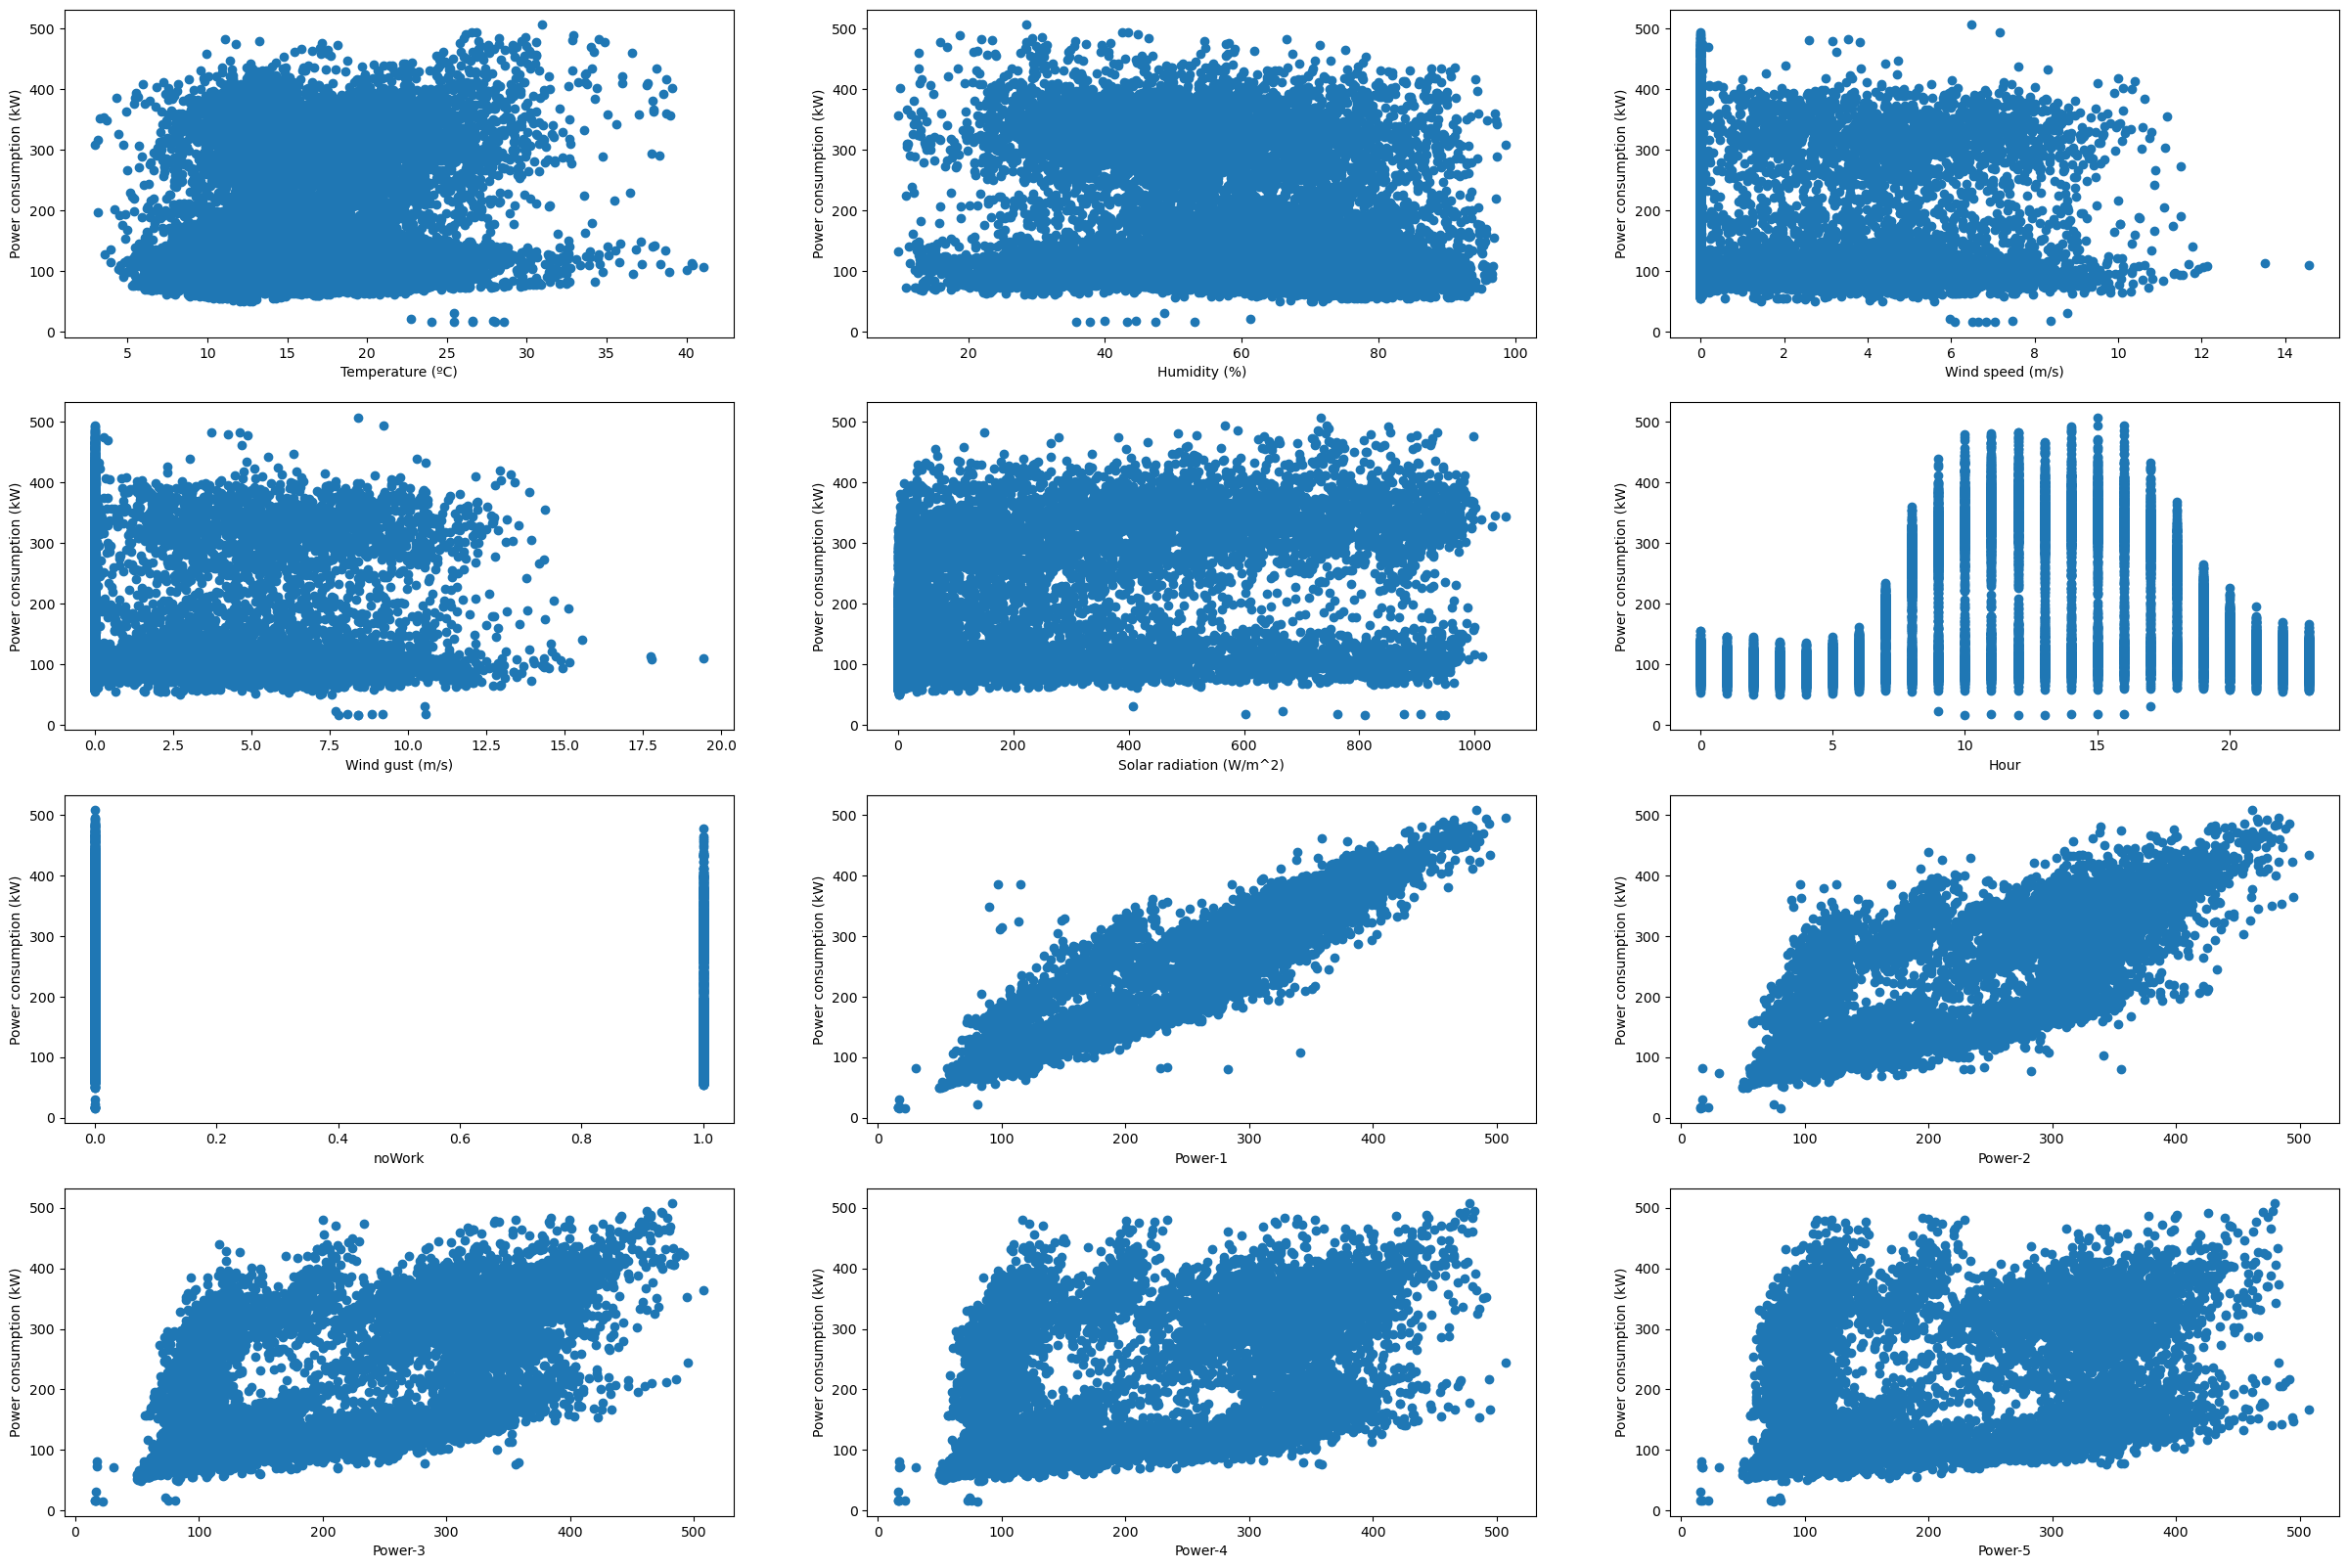

In [10]:
plt.figure(figsize=(30,20))
for i in range(1, len(df_help.columns)):
    plt.subplot(4,3,i, xlabel=str(df_help.columns[i]), ylabel='Power consumption (kW)')
    plt.scatter(df_help[df_help.columns[i]], df_help['Power consumption (kW)'])
plt.savefig('assets/params_scatter_plots.png')

plt.clf()
plt.plot()
for i in range(1, len(df_help.columns)):
    plt.subplot(4,3,i, xlabel=str(df_help.columns[i]), ylabel='Power consumption (kW)')
    plt.scatter(df_help[df_help.columns[i]], df_help['Power consumption (kW)'])
plt.savefig('assets/params_scatter_plots.svg')



<AxesSubplot:>

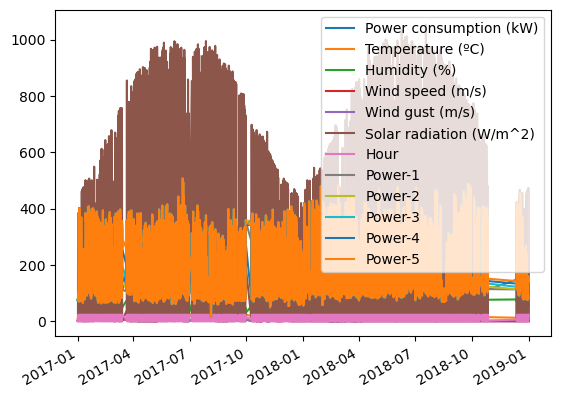

In [11]:
df_help.plot()